# Višeklasna klasifikacija 

In [190]:
import numpy as np
import pandas as pd
from tensorflow import keras

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import losses, optimizers

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection

from sklearn.decomposition import PCA

np.random.seed(10)

import category_encoders as ce

from keras.callbacks import TensorBoard

In [191]:
data = pd.read_csv('kddcup.csv.data_10_percent_corrected')

In [192]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [193]:
y = data['class']

In [194]:
y.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: class, dtype: int64

Zelimo da objedinimo klase koje imaju jednocifren i dvocifren broj instanci u jednu novu klasu pod imenom 'other_attacks'.

In [207]:
y.loc[y == 'spy.'] = 'other_attacks.'

In [196]:
y.loc[y == 'perl.'] = 'other_attacks.'

In [197]:
y.loc[y == 'phf.'] = 'other_attacks.'

In [198]:
y.loc[y == 'multihop.'] = 'other_attacks.'

In [199]:
y.loc[y == 'ftp_write.'] = 'other_attacks.'

In [200]:
y.loc[y == 'loadmodule.'] = 'other_attacks.'

In [201]:
y.loc[y == 'rootkit.'] = 'other_attacks.'

In [202]:
y.loc[y == 'imap.'] = 'other_attacks.'

In [203]:
y.loc[y == 'warezmaster.'] = 'other_attacks.'

In [204]:
y.loc[y == 'land.'] = 'other_attacks.'

In [205]:
y.loc[y == 'buffer_overflow.'] = 'other_attacks.'

In [206]:
y.loc[y == 'guess_passwd.'] = 'other_attacks.'

In [208]:
len(np.where(y == 'other_attacks.')[0])

179

In [209]:
y.value_counts()

smurf.            280790
neptune.          107201
normal.            97278
back.               2203
satan.              1589
ipsweep.            1247
portsweep.          1040
warezclient.        1020
teardrop.            979
pod.                 264
nmap.                231
other_attacks.       179
Name: class, dtype: int64

Klase cemo da kodiramo brojevima i napravicemo recnik, da bismo kasnije mogli da tumacimo matricu konfuzije.

In [317]:
y = y.astype('category')

In [212]:
d = dict(enumerate(y.cat.categories))

In [213]:
d

{0: 'back.',
 1: 'ipsweep.',
 2: 'neptune.',
 3: 'nmap.',
 4: 'normal.',
 5: 'other_attacks.',
 6: 'pod.',
 7: 'portsweep.',
 8: 'satan.',
 9: 'smurf.',
 10: 'teardrop.',
 11: 'warezclient.'}

In [214]:
y = y.cat.codes

In [215]:
len(np.unique(y))

12

In [216]:
X = data.drop(columns = ['class'], axis = 1)

In [217]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

In [218]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [219]:
X_train.shape

(330994, 41)

In [220]:
X_test.shape

(163027, 41)

U delu binarna klasifikacija smo naucili da atributi 'is_host_login' i 'num_outbound_cmds' imaju kao sve vrednosti 0, a to nam ne znaci za ocenjivanje klase, stoga ih izbacujemo iz podataka.

In [221]:
X_train = X_train.drop(columns = ['is_host_login', 'num_outbound_cmds'], axis = 1)

In [222]:
X_test = X_test.drop(columns = ['is_host_login', 'num_outbound_cmds'], axis = 1)

In [223]:
X_train.shape

(330994, 39)

In [224]:
X_test.shape

(163027, 39)

Da bismo primenili PCA algoritam, potrebno je skup podataka podeliti u dva skupa. Jedan sa numerickim podacima, a drugi sa kategorickim.

In [225]:
X_train_without_categorical = X_train.drop(columns = ['protocol_type', 'service', 'flag'], axis = 1)

In [226]:
X_test_without_categorical = X_test.drop(columns = ['protocol_type', 'service', 'flag'], axis = 1)

In [227]:
X_train_without_categorical.shape

(330994, 36)

In [228]:
X_test_without_categorical.shape

(163027, 36)

In [229]:
X_train_only_categorical = X_train.filter(['protocol_type', 'service', 'flag'])

In [230]:
X_test_only_categorical = X_test.filter(['protocol_type', 'service', 'flag'])

In [231]:
X_train_only_categorical.shape

(330994, 3)

In [232]:
X_test_only_categorical.shape

(163027, 3)

Enkodiramo kategoricke podatke.

In [233]:
encoderPCA = ce.BinaryEncoder(X_train_only_categorical)
X_train_only_categorical = encoderPCA.fit_transform(X_train_only_categorical)

In [234]:
X_test_only_categorical = encoderPCA.transform(X_test_only_categorical)

Primenjujemo standardizaciju na numericke podatke.

In [235]:
scalerPCA = preprocessing.StandardScaler()
scalerPCA.fit(X_train_without_categorical)
X_train_without_categorical = scalerPCA.transform(X_train_without_categorical)
X_test_without_categorical = scalerPCA.transform(X_test_without_categorical)

Primenjujemo PCA algoritam na numericke podatke i biramo da nam broj komponenti bude 20. Ovaj broj je eksperimentalno utvrdjen. Primenom PCA algoritma sacuvali smo 96% informacija.

In [236]:
pca = PCA(n_components=20)
pca.fit(X_train_without_categorical, y_train)
X_train_pca = pca.transform(X_train_without_categorical)
X_test_pca = pca.transform(X_test_without_categorical)

In [237]:
pca.explained_variance_ratio_

array([0.22281332, 0.12536241, 0.08942298, 0.08484129, 0.05128229,
       0.04230438, 0.03425662, 0.03200359, 0.03107929, 0.02809453,
       0.02777667, 0.02756823, 0.0265869 , 0.02538456, 0.02382271,
       0.02264831, 0.02114205, 0.02014711, 0.01770807, 0.01059392])

In [238]:
sum(pca.explained_variance_ratio_)

0.9648392188345213

In [239]:
X_train_pca.shape

(330994, 20)

In [240]:
X_test_pca.shape

(163027, 20)

In [241]:
X_train_only_categorical.shape

(330994, 16)

In [242]:
X_test_only_categorical.shape

(163027, 16)

Potrebno je nadovezati podatke dobijene pomocu PCA sa enkodiranim kategorickim podacima.

In [243]:
X_train_pca = np.concatenate([X_train_pca, X_train_only_categorical], axis=1)

In [244]:
X_train_pca.shape

(330994, 36)

In [245]:
X_test_pca = np.concatenate([X_test_pca, X_test_only_categorical], axis=1)

In [246]:
X_test_pca.shape

(163027, 36)

Zbog treniranja mreze koji ne koristi podatke smanjene dimenzije, kao i zbog kasnije upotrebe RFE, potrebno je enkodirati i standardizovati pocetni trening skup (koji nije podeljen na kategoricke i numericke).

In [247]:
encoder = ce.BinaryEncoder(X_train, cols = ['protocol_type', 'service', 'flag'])
X_train = encoder.fit_transform(X_train)

In [248]:
X_test = encoder.transform(X_test)

In [249]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Formiramo i treniramo mrezu.

In [250]:
model = Sequential()
model.add(Dense(units=150, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=12, activation='softmax'))

In [251]:
model.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [252]:
batch_size = 128
epochs = 30

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.2)

Train on 264795 samples, validate on 66199 samples
Epoch 1/30
264795/264795 [==============================] - 45s 171us/step - loss: 0.2008 - accuracy: 0.9768 - val_loss: 0.0225 - val_accuracy: 0.9950
Epoch 2/30
264795/264795 [==============================] - 41s 153us/step - loss: 0.0135 - accuracy: 0.9972 - val_loss: 0.0104 - val_accuracy: 0.9979
Epoch 3/30
264795/264795 [==============================] - 39s 145us/step - loss: 0.0075 - accuracy: 0.9984 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 4/30
264795/264795 [==============================] - 39s 149us/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9988
Epoch 5/30
264795/264795 [==============================] - 41s 153us/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0057 - val_accuracy: 0.9989
Epoch 6/30
264795/264795 [==============================] - 40s 152us/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0047 - val_accuracy: 0.9990
Epoch 7/30
264795/264795 [=================

In [253]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

163027/163027 [==============================] - 24s 145us/step
Test loss: 0.002280461698022376
Test accuracy: 0.9994847774505615


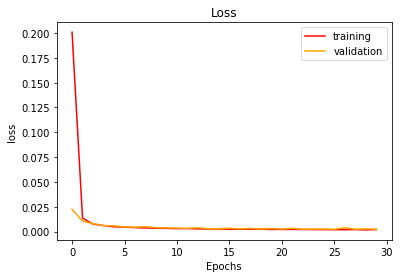

In [254]:
epochs = history.epoch

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, c='red', label = 'training')
plt.plot(epochs, validation_loss, c='orange', label='validation')
plt.legend(loc = 'best')
plt.show()

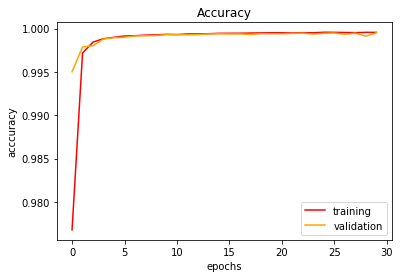

In [255]:
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acccuracy')
plt.plot(epochs, acc, c='red', label = 'training')
plt.plot(epochs, validation_acc, c = 'orange', label = 'validation')
plt.legend(loc = 'best')
plt.show()

Na osnovu grafika funkcije gubitka i tacnosti vidimo da model veoma dobro radi i na trening i na validacionom skupu.

In [256]:
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1)

In [257]:
y_test_classes = np.argmax(y_test, axis = 1)

In [258]:
from sklearn.metrics import confusion_matrix, classification_report

In [271]:
cm = confusion_matrix(y_test_classes, y_predicted_classes, labels = [0,1,2,3,4,5,6,7,8,9,10,11])
print(cm)

[[  727     0     0     0     0     0     0     0     0     0     0     0]
 [    0   407     0     2     2     0     0     0     1     0     0     0]
 [    0     0 35375     0     1     0     0     0     0     0     0     0]
 [    0     1     0    72     3     0     0     0     0     0     0     0]
 [    3     6     2     0 32071     2     0     1     4     0     0    13]
 [    0     0     0     0    11    47     0     0     0     0     0     1]
 [    0     0     0     0     0     0    87     0     0     0     0     0]
 [    0     0     1     0     1     0     0   341     0     0     0     0]
 [    0     0     0     2     5     0     0     0   517     0     0     0]
 [    0     0     0     0     1     0     0     0     0 92660     0     0]
 [    0     0     0     0     0     0     0     0     0     0   323     0]
 [    0     0     0     0    21     0     0     0     0     0     0   316]]


In [151]:
print(classification_report(y_test_classes, y_predicted_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       0.98      0.98      0.98       412
           2       1.00      1.00      1.00     35376
           3       0.95      0.95      0.95        76
           4       1.00      1.00      1.00     32102
           5       0.98      0.68      0.80        59
           6       1.00      1.00      1.00        87
           7       0.99      0.99      0.99       343
           8       0.98      0.98      0.98       524
           9       1.00      1.00      1.00     92661
          10       1.00      1.00      1.00       323
          11       0.97      0.93      0.95       337

    accuracy                           1.00    163027
   macro avg       0.99      0.96      0.97    163027
weighted avg       1.00      1.00      1.00    163027



In [262]:
import pylab as pl

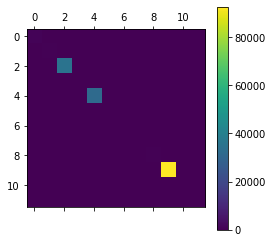

In [267]:
pl.matshow(confusion_matrix(y_test_classes, y_predicted_classes))
pl.colorbar()
pl.show()

Rezultati koje daje matrica konfuzije i izvestaj klasifikovanja su zadovoljavajuci. Pogledajmo na kojim klasama model gresi.

In [272]:
cm[11][4]

21

In [274]:
d[11]

'warezclient.'

In [275]:
d[4]

'normal.'

21 instancu koja je zapravo napad 'warezclient.' model je klasifikovao kao normalnu.

In [276]:
cm[4][11]

13

13 instanci koje su zapravo normalna konekcija model je klasifikovao kao napad 'warezclient.'

In [277]:
cm[5][4]

11

In [278]:
d[5]

'other_attacks.'

11 instanci koje pripadaju klasi 'other_attacks.' model je klasifikovao kao normalnu.

In [279]:
cm[4][1]

6

In [281]:
d[1]

'ipsweep.'

6 instanci koje pripadaju normalnoj konekciji model je klasifikovao kao napad 'ipsweep.'

In [282]:
cm[8][4]

5

In [283]:
d[8]

'satan.'

5 instanci koje pripadaju napadu 'satan.' model je klasifikovao kao normalnu konekciju.

## Model uz primenu PCA

Formiramo i treniramo mrezu nad podacima nad kojima je prethodno primenjen PCA algoritam.

In [284]:
modelPCA = Sequential()
modelPCA.add(Dense(units=150, input_dim=X_train_pca.shape[1], activation='relu'))
modelPCA.add(Dense(units=50, activation='relu'))
modelPCA.add(Dense(units=12, activation='softmax'))

In [285]:
modelPCA.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [286]:
batch_size = 128
epochs = 30

historyPCA = modelPCA.fit(X_train_pca, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.2)

Train on 264795 samples, validate on 66199 samples
Epoch 1/30
264795/264795 [==============================] - 43s 161us/step - loss: 0.2293 - accuracy: 0.9757 - val_loss: 0.0292 - val_accuracy: 0.9911
Epoch 2/30
264795/264795 [==============================] - 39s 146us/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.0139 - val_accuracy: 0.9966
Epoch 3/30
264795/264795 [==============================] - 37s 140us/step - loss: 0.0112 - accuracy: 0.9970 - val_loss: 0.0101 - val_accuracy: 0.9975
Epoch 4/30
264795/264795 [==============================] - 38s 144us/step - loss: 0.0086 - accuracy: 0.9979 - val_loss: 0.0082 - val_accuracy: 0.9981
Epoch 5/30
264795/264795 [==============================] - 39s 149us/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0073 - val_accuracy: 0.9982
Epoch 6/30
264795/264795 [==============================] - 37s 141us/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0069 - val_accuracy: 0.9984
Epoch 7/30
264795/264795 [=================

In [287]:
score = modelPCA.evaluate(X_test_pca, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

163027/163027 [==============================] - 40s 247us/step
Test loss: 0.0039198086932115675
Test accuracy: 0.9990983009338379


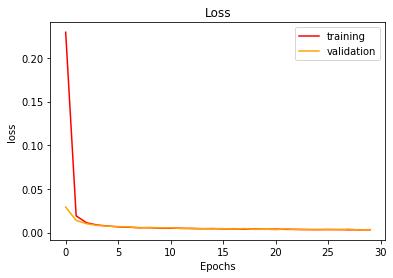

In [288]:
epochs = historyPCA.epoch

loss = historyPCA.history['loss']
validation_loss = historyPCA.history['val_loss']

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, c='red', label = 'training')
plt.plot(epochs, validation_loss, c='orange', label='validation')
plt.legend(loc = 'best')
plt.show()

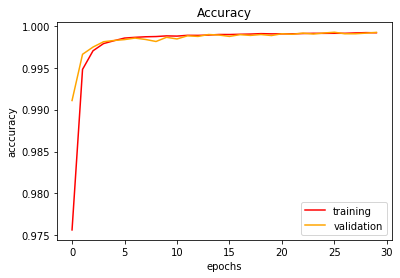

In [289]:
acc = historyPCA.history['accuracy']
validation_acc = historyPCA.history['val_accuracy']

plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acccuracy')
plt.plot(epochs, acc, c='red', label = 'training')
plt.plot(epochs, validation_acc, c = 'orange', label = 'validation')
plt.legend(loc = 'best')
plt.show()

Na osnovu grafika funkcije gubitka i tacnosti vidimo da model dobro radi i na trening i na validacionim podacima.

In [290]:
y_predicted_pca = modelPCA.predict(X_test_pca)
y_predicted_classes_pca = np.argmax(y_predicted_pca, axis = 1)

In [291]:
y_test_classes = np.argmax(y_test, axis = 1)

In [293]:
cm_pca = confusion_matrix(y_test_classes, y_predicted_classes_pca)
print(cm_pca)

[[  724     0     0     0     3     0     0     0     0     0     0     0]
 [    0   407     0     2     3     0     0     0     0     0     0     0]
 [    0     0 35375     1     0     0     0     0     0     0     0     0]
 [    0     1     0    64    11     0     0     0     0     0     0     0]
 [    9    11     3     0 32041     5     0     2     1     1     0    29]
 [    0     0     1     0    13    42     0     0     0     0     0     3]
 [    0     0     0     0     3     0    84     0     0     0     0     0]
 [    0     0     2     0     1     0     0   340     0     0     0     0]
 [    0     0     0     0    10     0     0     7   507     0     0     0]
 [    0     0     0     0     2     0     0     0     0 92659     0     0]
 [    0     0     0     0     0     0     0     0     0     0   323     0]
 [    0     1     0     0    22     0     0     0     0     0     0   314]]


In [294]:
print(classification_report(y_test_classes, y_predicted_classes_pca))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       727
           1       0.97      0.99      0.98       412
           2       1.00      1.00      1.00     35376
           3       0.96      0.84      0.90        76
           4       1.00      1.00      1.00     32102
           5       0.89      0.71      0.79        59
           6       1.00      0.97      0.98        87
           7       0.97      0.99      0.98       343
           8       1.00      0.97      0.98       524
           9       1.00      1.00      1.00     92661
          10       1.00      1.00      1.00       323
          11       0.91      0.93      0.92       337

    accuracy                           1.00    163027
   macro avg       0.97      0.95      0.96    163027
weighted avg       1.00      1.00      1.00    163027



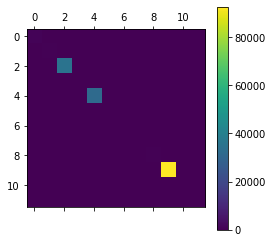

In [295]:
pl.matshow(confusion_matrix(y_test_classes, y_predicted_classes_pca))
pl.colorbar()
pl.show()

Rezultati koje daje matrica konfuzije i izvestaj klasifikovanja su zadovoljavajuci. Pogledajmo na kojim klasama model gresi.

In [296]:
cm_pca[4][11]

29

In [297]:
d[4]

'normal.'

In [298]:
d[11]

'warezclient.'

29 instanci koje pripadaju normalnoj konekciji model je klasifikovao kao napad 'warezclient.'

In [299]:
cm_pca[11][4]

22

22 instance koje pripadaju napadu 'warezclient.' model je klasifikovao kao normalnu konekciju.

In [302]:
cm_pca[5][4]

13

In [303]:
d[5]

'other_attacks.'

13 instanci koje pripadaju napadu 'other_attacks' model je klasifikovao kao normalnu konekciju.

In [300]:
cm_pca[3][4]

11

In [301]:
d[3]

'nmap.'

11 instanci koje pripadaju napadu 'nmap' model je klasifikovao kao normalnu konekciju.

In [304]:
cm_pca[4][1]

11

In [305]:
d[1]

'ipsweep.'

11 instanci koje pripadaju normalnoj konekciji model je klasifikovao kao napad 'ipsweep.'.

In [306]:
cm_pca[8][4]

10

In [307]:
d[8]

'satan.'

10 instanci koje pripadaju napadu 'satan.' model je klasifikovao kao normalnu konekciju.

## Model uz primenu RFE

In [308]:
X_train.shape

(330994, 52)

In [309]:
y_train.shape

(330994, 12)

In [310]:
np.argmax(y_train, axis = 1).shape

(330994,)

In [311]:
X_test.shape

(163027, 52)

Formiramo model linearne regresije i prosledjujemo algoritmu RFE kao i broj atributa koje zelimo da izabere. Eksperimentalno je utvrdjeno da najbolje rezultate daje za 30 atributa. Nakon toga se podaci transformisu u skladu sa rezultatima RFE-a.

In [312]:
model_l = linear_model.LinearRegression()

rfe = feature_selection.RFE(model_l, n_features_to_select=30, verbose=1)

y_train_one_dimension = np.argmax(y_train, axis = 1)

rfe.fit(X_train, y_train_one_dimension)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


In [313]:
rfe.ranking_

array([11, 19,  1,  1, 23, 17,  8,  6,  1,  1,  1,  1, 20, 16,  1,  1,  1,
       10, 14,  9,  1, 13,  2, 21,  1,  1, 22,  4,  1, 18, 12, 15,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  3,  5,  7,  1,  1,  1,  1,  1,  1,  1,
        1])

Formiramo i treniramo mrezu nad podacima koje smo dobili pomocu RFE algoritma.

In [314]:
modelRFE = Sequential()
modelRFE.add(Dense(units=150, input_dim=X_train_rfe.shape[1], activation='relu'))
modelRFE.add(Dense(units=50, activation='relu'))
modelRFE.add(Dense(units=12, activation='softmax'))

In [315]:
modelRFE.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [316]:
batch_size = 128
epochs = 30

historyRFE = modelRFE.fit(X_train_rfe, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.2)

Train on 264795 samples, validate on 66199 samples
Epoch 1/30
264795/264795 [==============================] - 42s 159us/step - loss: 0.1915 - accuracy: 0.9694 - val_loss: 0.0331 - val_accuracy: 0.9903
Epoch 2/30
264795/264795 [==============================] - 40s 153us/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0182 - val_accuracy: 0.9940
Epoch 3/30
264795/264795 [==============================] - 38s 145us/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.0110 - val_accuracy: 0.9974
Epoch 4/30
264795/264795 [==============================] - 38s 144us/step - loss: 0.0085 - accuracy: 0.9979 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 5/30
264795/264795 [==============================] - 39s 148us/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.0070 - val_accuracy: 0.9977
Epoch 6/30
264795/264795 [==============================] - 38s 144us/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0061 - val_accuracy: 0.9983
Epoch 7/30
264795/264795 [=================

In [178]:
scoreRFE = modelRFE.evaluate(X_test_rfe, y_test)
print('Test loss:', scoreRFE[0])
print('Test accuracy:', scoreRFE[1])

163027/163027 [==============================] - 37s 225us/step
Test loss: 0.004489319530296752
Test accuracy: 0.9984971880912781


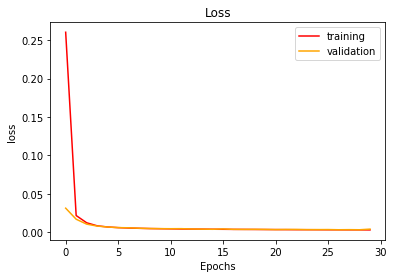

In [179]:
epochs = historyRFE.epoch

loss = historyRFE.history['loss']
validation_loss = historyRFE.history['val_loss']

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, c='red', label = 'training')
plt.plot(epochs, validation_loss, c='orange', label='validation')
plt.legend(loc = 'best')
plt.show()

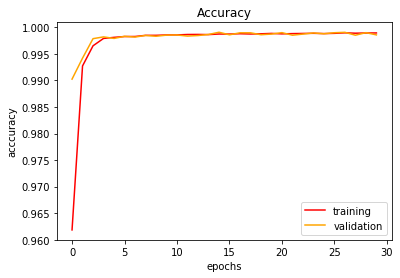

In [180]:
acc = historyRFE.history['accuracy']
validation_acc = historyRFE.history['val_accuracy']

plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acccuracy')
plt.plot(epochs, acc, c='red', label = 'training')
plt.plot(epochs, validation_acc, c = 'orange', label = 'validation')
plt.legend(loc = 'best')
plt.show()

Na osnovu grafika funkcije gubitka i tacnosti vidimo da model dobro radi i na trening i na validacionim podacima.

In [181]:
y_predicted_rfe = modelRFE.predict(X_test_rfe)
y_predicted_classes_rfe = np.argmax(y_predicted_rfe, axis = 1)

In [321]:
cm_rfe = confusion_matrix(y_test_classes, y_predicted_classes_rfe)
print(cm_rfe)

[[  725     0     0     0     0     2     0     0     0     0     0     0]
 [    0   382     0    26     3     0     0     0     1     0     0     0]
 [    0     0 35372     0     1     2     0     1     0     0     0     0]
 [    0     1     0    72     3     0     0     0     0     0     0     0]
 [    2     3     2     3 32076     4     0     1     7     0     0     4]
 [    0     0     1     0    19    37     0     0     0     0     0     2]
 [    0     0     0     0     0     0    87     0     0     0     0     0]
 [    0     0     0     0     3     0     0   340     0     0     0     0]
 [    1     0     0     2     6     0     0     0   515     0     0     0]
 [    0     0     0     0    17     0     0     0     0 92644     0     0]
 [    0     0     0     0     0     0     0     0     0     0   323     0]
 [    0     0     0     0   128     0     0     0     0     0     0   209]]


In [183]:
print(classification_report(y_test_classes, y_predicted_classes_rfe))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       0.99      0.93      0.96       412
           2       1.00      1.00      1.00     35376
           3       0.70      0.95      0.80        76
           4       0.99      1.00      1.00     32102
           5       0.82      0.63      0.71        59
           6       1.00      1.00      1.00        87
           7       0.99      0.99      0.99       343
           8       0.98      0.98      0.98       524
           9       1.00      1.00      1.00     92661
          10       1.00      1.00      1.00       323
          11       0.97      0.62      0.76       337

    accuracy                           1.00    163027
   macro avg       0.95      0.92      0.93    163027
weighted avg       1.00      1.00      1.00    163027



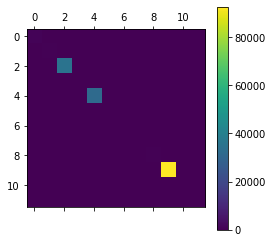

In [320]:
pl.matshow(confusion_matrix(y_test_classes, y_predicted_classes))
pl.colorbar()
pl.show()

Rezultati koje daje matrica konfuzije i izvestaj klasifikovanja su zadovoljavajuci. Pogledajmo na kojim klasama model gresi.

In [322]:
cm_rfe[11][4]

128

In [323]:
d[11]

'warezclient.'

In [324]:
d[4]

'normal.'

128 instanci koje pripadaju napadu 'warezclient.' model je klasifikovao kao normalnu konekciju.

In [325]:
cm_rfe[1][3]

26

In [326]:
d[1]

'ipsweep.'

In [327]:
d[3]

'nmap.'

26 instanci koje pripadaju napadu 'ipsweep.' model je klasifikovao kao napad 'nmap.'.

In [328]:
cm_rfe[5][4]

19

In [329]:
d[5]

'other_attacks.'

19 instanci koje pripadaju napadu 'other_attacks.' model je klasifovao kao normalnu konekciju.

In [330]:
cm_rfe[9][4]

17

In [331]:
d[9]

'smurf.'

17 instanci koje pripadaju napadu 'smurf.' model je klasifikovao kao normalnu konekciju.

Mozemo primetiti da je u svakom modelu najvise gresaka bilo zbog mesanja normalne konekcije i warezclient napada.